In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
import seaborn as sns
from skimage import exposure, filters, color
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import  Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

2024-04-03 18:05:21.241131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 18:05:21.241232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 18:05:21.387102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data=pd.read_csv('/kaggle/input/diabetic-retinopathy-resized/trainLabels.csv')

In [3]:
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [4]:
data['hasDR'] = 0
data.loc[data['level'] != 0, 'hasDR'] = 1

In [5]:
data.head()

,image,level,hasDR
0,10_left,0,0
1,10_right,0,0
2,13_left,0,0
3,13_right,0,0
4,15_left,1,1


<Axes: xlabel='hasDR', ylabel='count'>

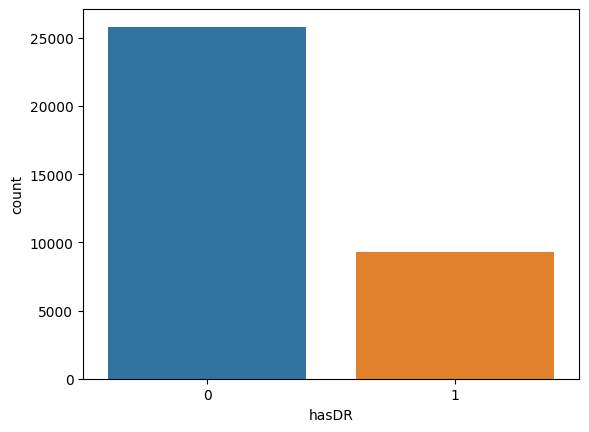

In [6]:
sns.countplot(x=data['hasDR'])

In [7]:
has_dr_data=data[data['hasDR'] == 1].head(10000)
no_dr_data=data[data['hasDR'] == 0].head(10000)

In [8]:
balanced_data=pd.concat([has_dr_data, no_dr_data])
shuffled_indices=list(balanced_data.index)
np.random.shuffle(shuffled_indices)
balanced_data=balanced_data.reindex(shuffled_indices).reset_index(drop=True)
balanced_data.head(10)

,image,level,hasDR
0,3454_right,2,1
1,17548_left,2,1
2,15242_left,0,0
3,5935_right,0,0
4,216_left,0,0
5,7109_left,0,0
6,15321_right,0,0
7,12986_right,0,0
8,15590_left,4,1
9,3543_right,0,0


<Axes: xlabel='hasDR', ylabel='count'>

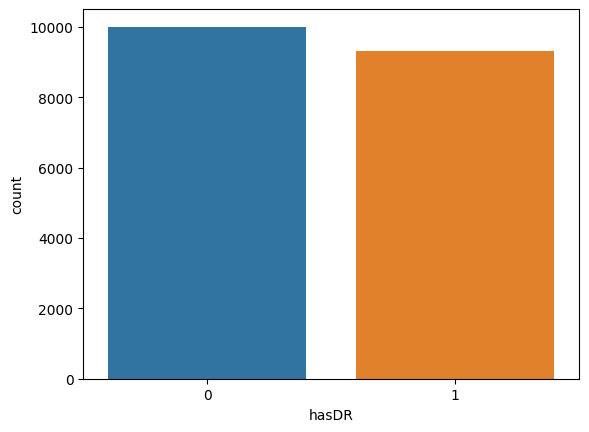

In [9]:
sns.countplot(x=balanced_data['hasDR'])

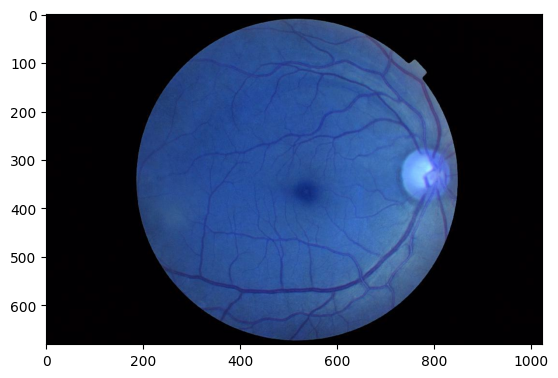

In [10]:
directory = "/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train"
files = os.listdir(directory)
image_path = os.path.join(directory, files[6695])
image1 = cv2.imread(image_path)
plt.imshow( image1)

In [11]:
def preprocess_image(image):
    # Convert image to grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
#     # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     clahe_image = clahe.apply(gray_image)
    
#     # Apply Gaussian blur to reduce noise
#     blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)
    
#     # Apply Canny edge detection
#     edges = cv2.Canny(blurred_image, threshold1=30, threshold2=100)
    img_ben = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), 10), -3.5, 80)
    return img_ben

(681, 1024, 3)


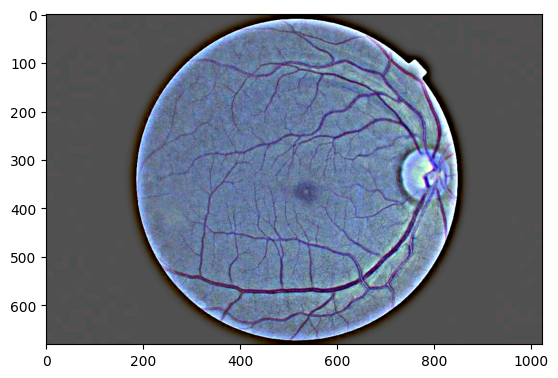

In [12]:
out=preprocess_image(image1)
print(out.shape)
plt.imshow(out,cmap='gray')

In [13]:
source_dir = "/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train"
destination_dir = "/kaggle/working/"

In [14]:
resized_data_dir = os.path.join(destination_dir, "resized_data")
os.makedirs(resized_data_dir, exist_ok=True)
os.makedirs(os.path.join(resized_data_dir, "hasDR"), exist_ok=True)  # Ensure intermediate directories are created
os.makedirs(os.path.join(resized_data_dir, "noDR"), exist_ok=True)   # Ensure intermediate directories are created

In [15]:
clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(8, 8))
for index, row in balanced_data.iterrows():
    source_path = os.path.join(source_dir, row['image'] + '.jpeg')
    if row['hasDR'] == 1:
        destination_path = os.path.join(resized_data_dir, "hasDR", row['image'] + '.jpeg')
    else:
        destination_path = os.path.join(resized_data_dir, "noDR", row['image'] + '.jpeg')

    # Read the image using OpenCV
    image = cv2.imread(source_path)
    
    # Resize the image
    image_resized = cv2.resize(image, (224, 224),3)
    
    out=preprocess_image(image_resized)
    
    # Save the preprocessed image
    cv2.imwrite(destination_path, out)

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split data into training and validation sets
)

In [17]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/resized_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # adjust class mode based on your problem
    subset='training'  # specify training subset
)

Found 15453 images belonging to 2 classes.


In [18]:
validation_generator = train_datagen.flow_from_directory(
    '/kaggle/working/resized_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # adjust class mode based on your problem
    subset='validation'  # specify validation subset
)

Found 3863 images belonging to 2 classes.


In [19]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(.15),
    Dense(64, activation='relu'),
    Dropout(.15),
    Dense(8, activation='relu'),
    Dropout(.15),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [22]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    batch_size=32,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
  1/483 ━━━━━━━━━━━━━━━━━━━━ 13:09:17 98s/step - accuracy: 0.5312 - loss: 0.7789

I0000 00:00:1712168086.889904     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


483/483 ━━━━━━━━━━━━━━━━━━━━ 357s 537ms/step - accuracy: 0.5336 - loss: 0.6905 - val_accuracy: 0.5177 - val_loss: 0.6965
Epoch 2/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 187s 383ms/step - accuracy: 0.6457 - loss: 0.6292 - val_accuracy: 0.6479 - val_loss: 0.6438
Epoch 3/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 188s 386ms/step - accuracy: 0.6803 - loss: 0.6038 - val_accuracy: 0.6834 - val_loss: 0.5874
Epoch 4/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 188s 384ms/step - accuracy: 0.6933 - loss: 0.5884 - val_accuracy: 0.6922 - val_loss: 0.5719
Epoch 5/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 192s 393ms/step - accuracy: 0.7005 - loss: 0.5756 - val_accuracy: 0.7013 - val_loss: 0.5703
Epoch 6/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 186s 381ms/step - accuracy: 0.7084 - loss: 0.5633 - val_accuracy: 0.5677 - val_loss: 0.7713
Epoch 7/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 192s 394ms/step - accuracy: 0.7186 - loss: 0.5542 - val_accuracy: 0.7015 - val_loss: 0.5545
Epoch 8/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 187s 382ms/step - accuracy: 0.7210 - loss: 0.55

In [24]:
validation_steps = len(validation_generator)
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_steps)

121/121 ━━━━━━━━━━━━━━━━━━━━ 37s 304ms/step - accuracy: 0.7100 - loss: 0.5417


In [25]:
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Validation Loss: 0.5349637269973755
Validation Accuracy: 0.713952898979187


In [32]:
# model.save('/kaggle/working/binary_model.h5')

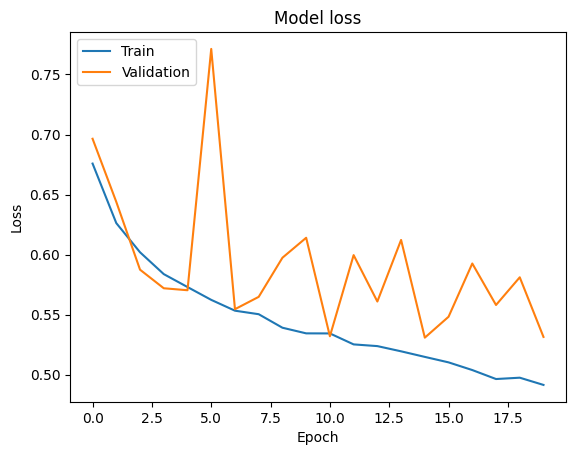

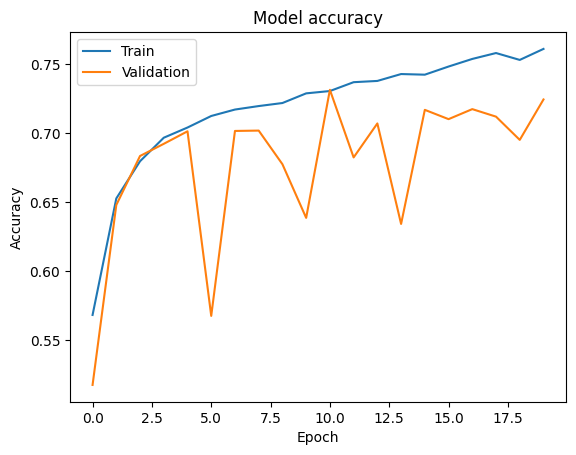

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()